In [1]:
import scienceplots

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

%matplotlib inline

plt.style.use('science')
plt.rcParams['figure.dpi'] = 220
plt.rcParams['figure.figsize'] = (6, 4)

# Some Python Arcana

Like most programing languages Python is not always intuitive; the language itself is over 30 years old and it carries with it the baggage of over 60 years of programming language design. Lets start by looking at a few examples of this baggage which can both trip you up and be used to your advantage.

## The Two Types of Types

Python types are generally either what is called "Mutable" or "Immutable", or what other languages call "Pass-by-Reference" or "Pass-by-Value" respectively. `int`, `float` , `str`, and `tuple` are all examples of "Immutable" types and variables of these types generally act the way you would expect; that is when you go to change the value of a variable it is replaced with the new value:

In [2]:
a = 4
b = a
b += 1

print(a, b)

4 5


Variables containing "Mutable" are better thought of as bookmarks (or references) to the underlying data which they contain, the consequence of this being that multiple variables can contain the same bookmark, and changing the data behind one will be reflected when you use the other to look it up:

In [3]:
c = ["Hi", "my", "name", "is", "Aled"]
d = c

print(c, d)

['Hi', 'my', 'name', 'is', 'Aled'] ['Hi', 'my', 'name', 'is', 'Aled']


In [4]:
d[4] = "Jeff"

print(c, d)

['Hi', 'my', 'name', 'is', 'Jeff'] ['Hi', 'my', 'name', 'is', 'Jeff']


You can of course replace a bookmark with another and this is effectively the same operation when you change a variable which contains an Immutable type:

In [5]:
d = []

print(c, d)

['Hi', 'my', 'name', 'is', 'Jeff'] []


## Function Names == Variable Names

We often think of function names as a magical incantation, but really they're just a variable name that supports a `()` operation in the same way a list supports a `[]` operation. Let's see what this means in practice:

In [6]:
def say_hi():
    print('Hi')

say_hi()

also_say_hi = say_hi
also_say_hi()

Hi
Hi


Which leads to two obvious questions:

In [7]:
print(say_hi, also_say_hi)
type(say_hi)

<function say_hi at 0x7f607f2e0e00> <function say_hi at 0x7f607f2e0e00>


function

We can also start to do crazy things like build functions to generate functions:

In [8]:
def hi_generator(name):
    def hi():
        print("Hi {:s}!!!!".format(name))
    return hi

hi_20cl = hi_generator("20CL")

In [9]:
hi_20cl()

Hi 20CL!!!!


In [10]:
hi_generator("Bob")()
hi_generator("UCSB")

Hi Bob!!!!


<function __main__.hi_generator.<locals>.hi()>

Now you may have realized by now that we can have an integer (say `3`) without ever giving it a variable name, we do this all the time when we do math in python. Can we do the same with functions?

In [11]:
(lambda x: x + 2)(2)

4

In [12]:
print(lambda x: x + 2)

<function <lambda> at 0x7f607f2e2840>


Of course if we ever want to give them a name we can:

In [13]:
summer = lambda a, b: a + b
print(summer)

summer(1, 2)

<function <lambda> at 0x7f607f2e31a0>


3

# Fitting Nonlinear Things

Now that we've done a bit of a python refresher lets try generating some data for a damped harmonic oscillator with $\omega_0 = 44000$, $\gamma = 4000$, and an offset of 5 and fitting a model to it:

Text(0, 0.5, 'Position')

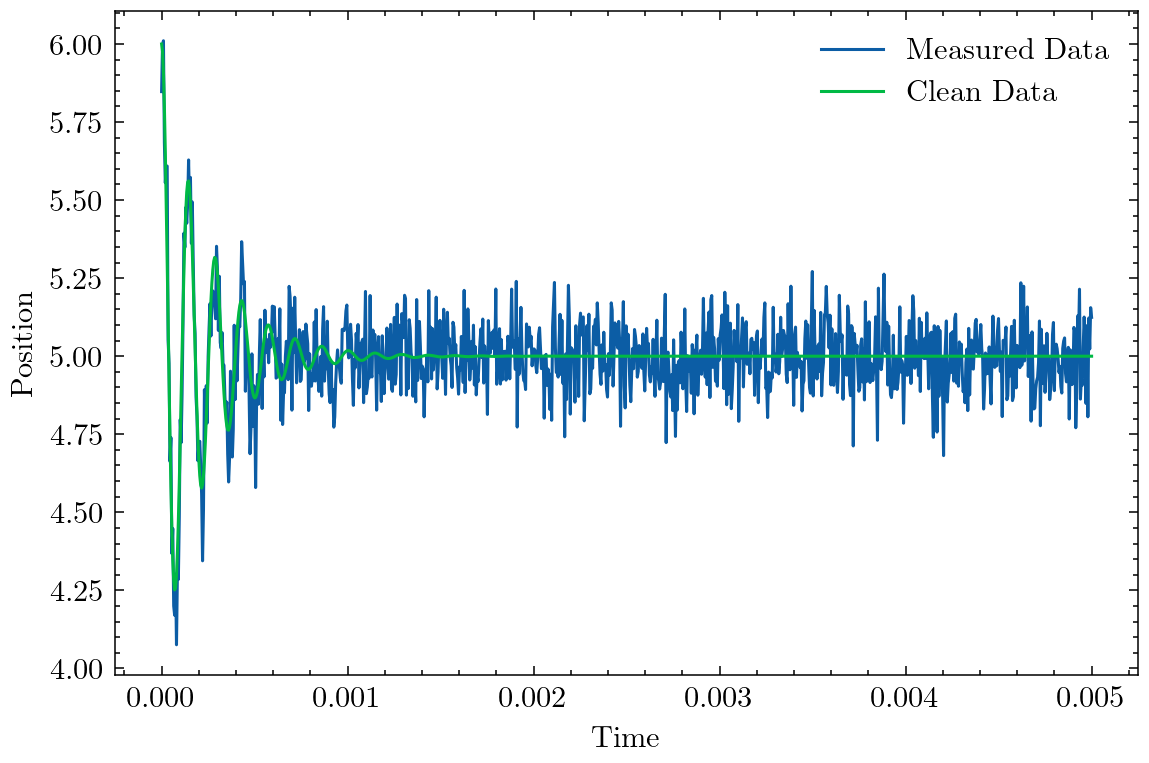

In [14]:
# We'll talk about whats going on here later if we have time

sol = solve_ivp(lambda _, y: [y[1], -(44000**2)*y[0] - 2*4000*y[1]], (0, 0.005), [1, 0], t_eval=np.linspace(0, 0.005, 1000))

t, x = sol.t, sol.y[0,::]
x_meas = x + np.random.normal(loc=0, scale=0.1, size=t.size) + 5

plt.plot(t, x_meas, label="Measured Data")
plt.plot(t, x + 5, label='Clean Data')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')

In [15]:
model = lambda t, A, g, w, o: A*np.exp(-g*t)*np.cos(np.sqrt(g**2 + w**2) * t) + o
p, _ = curve_fit(model, t, x_meas)

p

array([-0.25729484, -6.7201511 ,  0.0533585 ,  5.25854933])

Text(0, 0.5, 'Position')

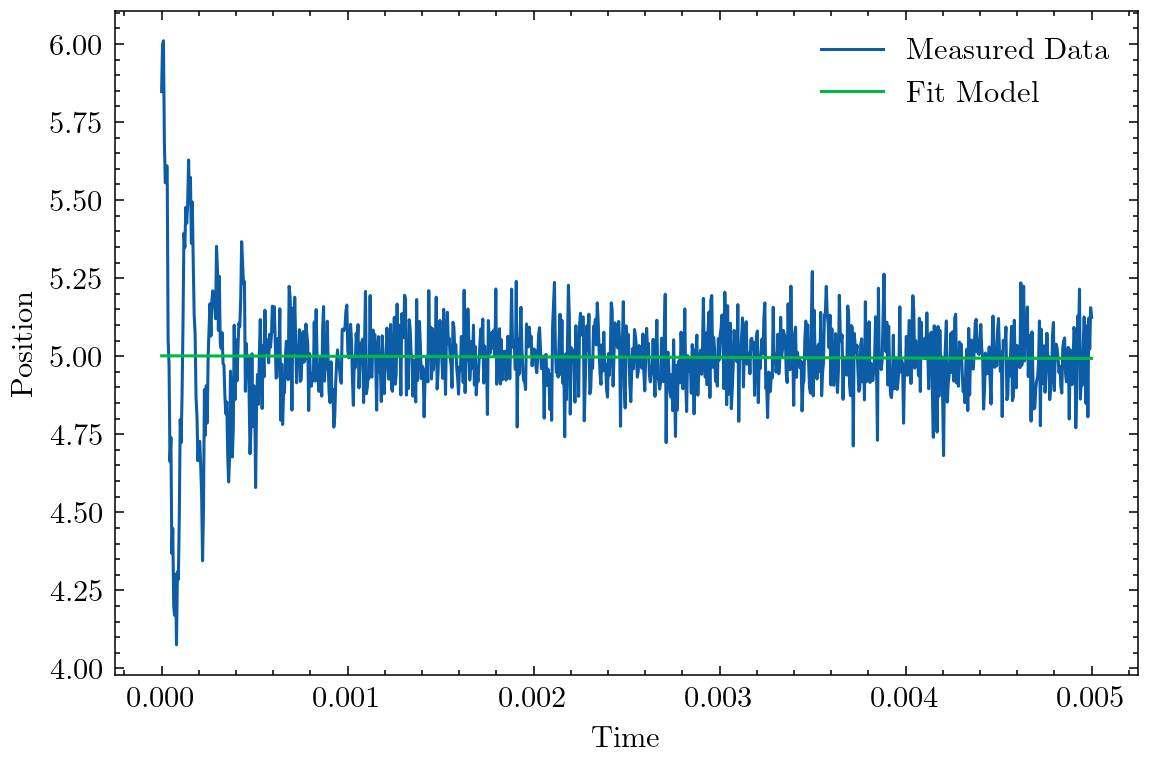

In [16]:
plt.plot(t, x_meas, label="Measured Data")
plt.plot(t, model(t, *p), label='Fit Model')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')

Well that didn't work, lets use some of the things we developed to try and see why:

In [17]:
def fit_tracker(model):
    track = []
    def tracked_model(x, *p):
        track.append(p)
        return model(x, *p)
    return tracked_model, track

tm, h = fit_tracker(model)

p, _ = curve_fit(tm, t, x_meas, p0 = np.ones_like(p))

And lets plot the progression of the fit (getting darker as the fit progresses):

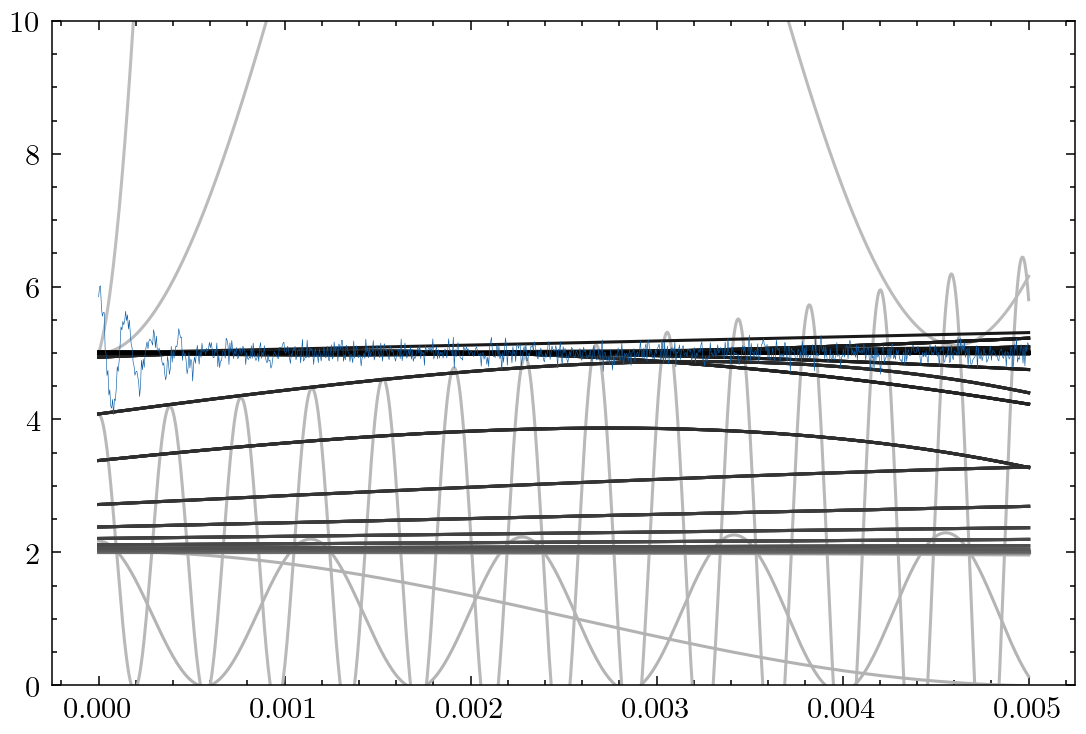

In [23]:
plt.figure()
for i, p in enumerate(h):
    if i % 10:
        plt.plot(t, model(t, *p), c = (0.9*np.array([1, 1, 1])*(len(h)-i)/len(h))**2)
plt.ylim(0, 10)
plt.plot(t, x_meas, lw=0.2)

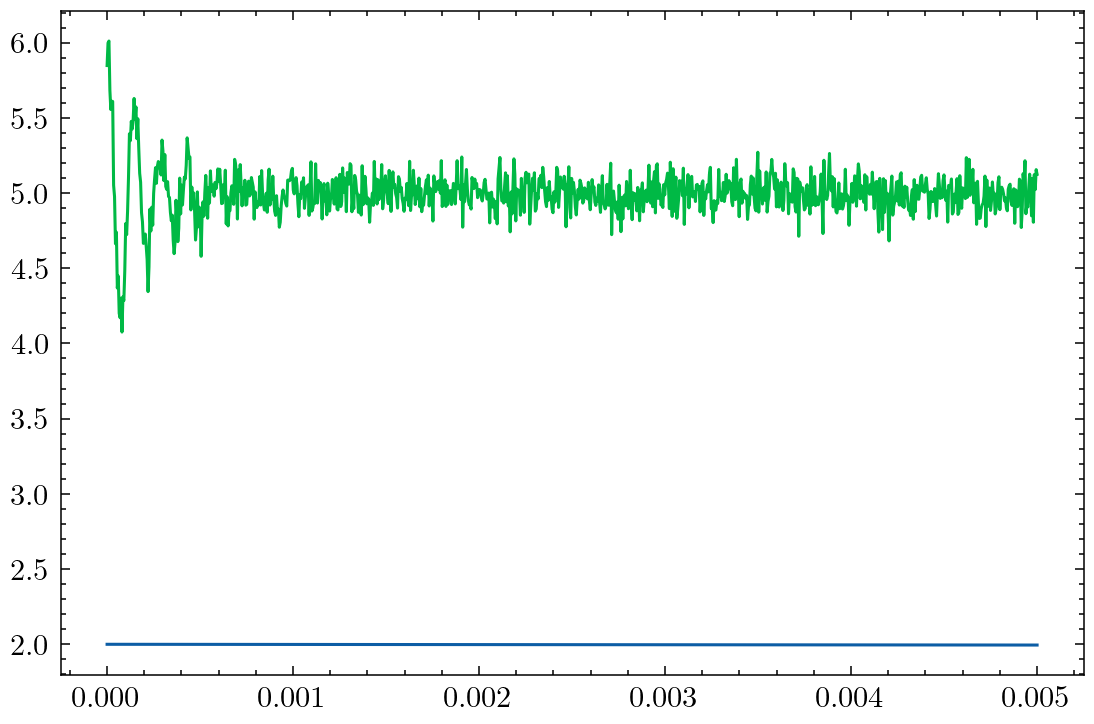

In [19]:
plt.plot(t, model(t, *h[0]))
plt.plot(t, x_meas)

Looking at the progression of the fit can anyone tell me what happened? How do we correct it?

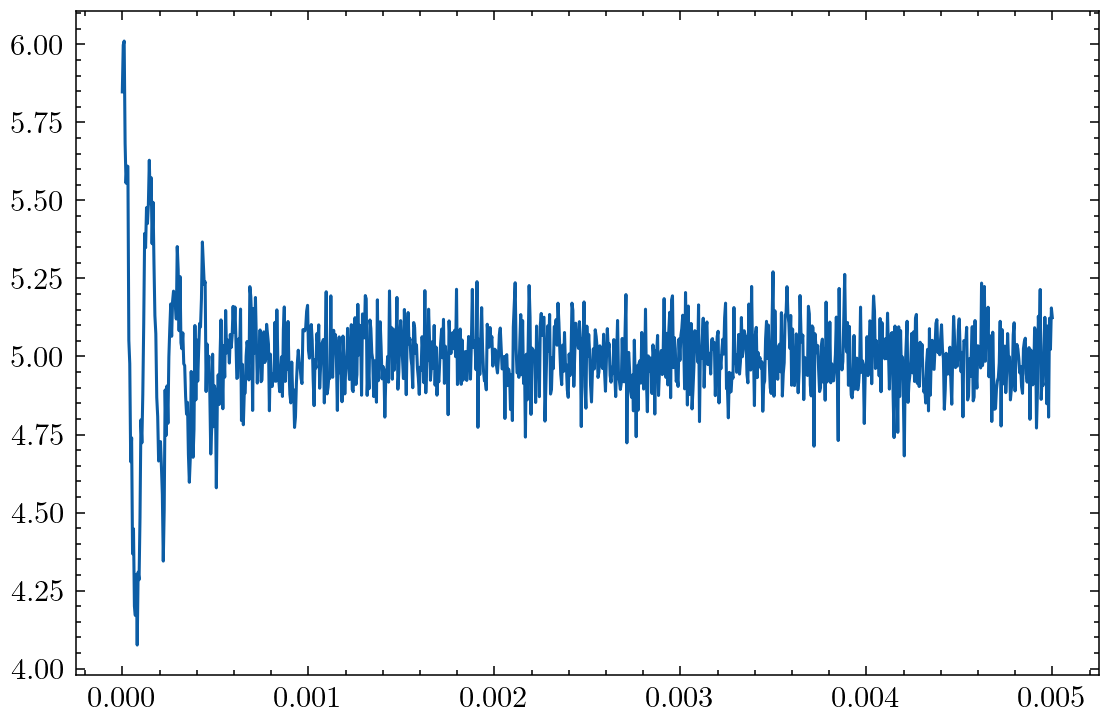

In [20]:
plt.plot(t, x_meas)

[1.0398648778357948, 4152.843142116687, 43075.92839991968, 4.995954363289466]
[0.03853444253200096, 223.14075222381973, 164.9484711220958, 0.0031627689815704996]


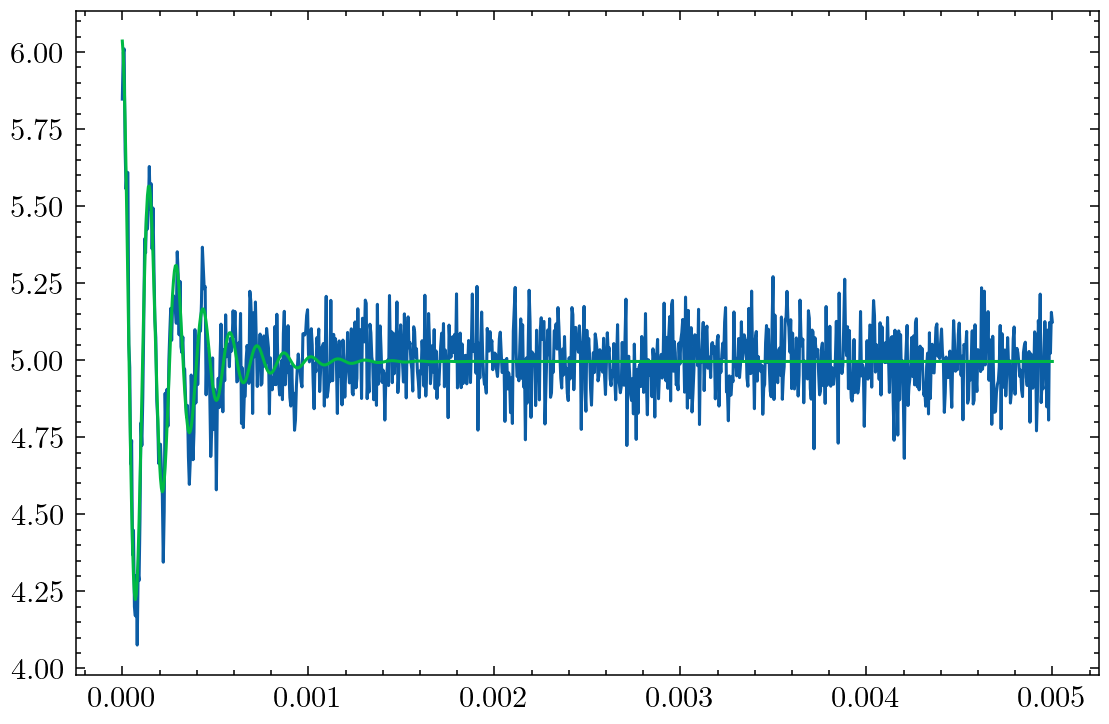

In [21]:
g0 = 1/0.0004
w0 = 2*np.pi/0.0002
o0 = 5.1
A0 = 0.9

p0 = [A0, g0, w0, o0]
plt.plot(t, x_meas)

p, pcov = curve_fit(model, t, x_meas, p0=p0, sigma=np.ones_like(t)*0.1, absolute_sigma=True)
plt.plot(t, model(t, *p))

print(list(p))
print(list(np.sqrt(np.diagonal(pcov))))

# What was that simulation thing?

Scipy has a handy tool called `solve_ivp`; It's a numerical integrator that can solve first order coupled differential equations. Lets look at the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

The differential equation for a damped harmonic oscillator is:

$$
\frac{d^2x}{dt^2} + 2\gamma \frac{dx}{dt} + \omega_0^2 x = 0
\implies \frac{d^2x}{dt^2} = - 2\gamma \frac{dx}{dt} - \omega_0^2 x
$$

But this is a 2nd-order ODE, can we rephrase it as a system of first-order ODEs?

Well if we rewrite things like this: 

$$
\frac{dx}{dt} = x^\prime
$$
$$
\frac{dx^\prime}{dt} = \frac{d^2x}{dt^2} = -2\gamma \frac{dx}{dt} - \omega_0^2 x = -2\gamma x^\prime - \omega_0^2 x
$$

Then we have two coupled first-order differential equations in the coordinates $x$ and $x^\prime$, if we write a function that takes these coordinates and returns their derivatives:

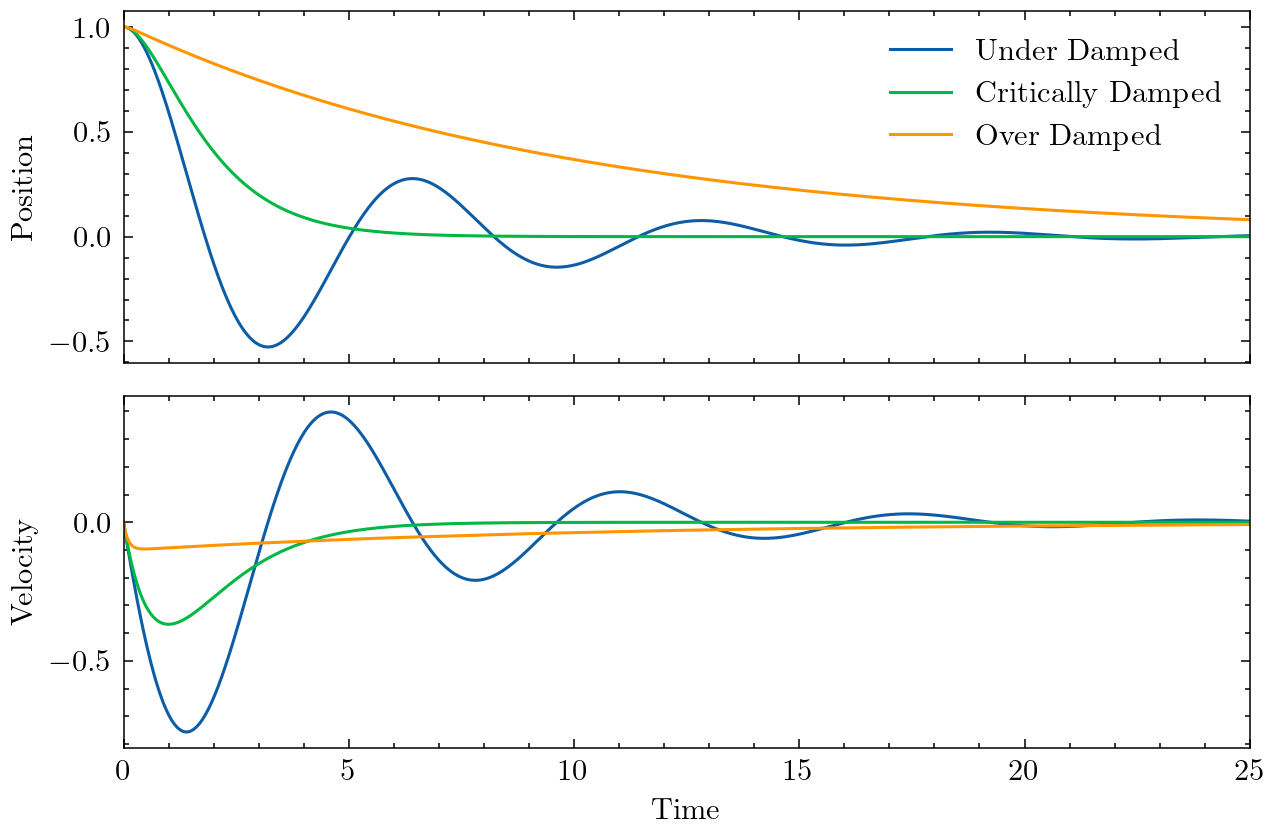

In [22]:
def oscillator(w0, gamma):
    def derivs(t, coords):
        x, xp = coords
        dx = xp
        dxp = -2*gamma*xp - w0*w0*x 
        return [dx, dxp]
    return derivs

ts = np.linspace(0, 25, 1000)

_, (ax1, ax2) = plt.subplots(2, sharex=True)

under_damped = oscillator(1, 0.2)
usol = solve_ivp(under_damped, (0, 25), [1, 0], t_eval=ts)
ax1.plot(usol.t, usol.y[0], label = "Under Damped")
ax2.plot(usol.t, usol.y[1])


crit_damped = oscillator(1, 1)
csol = solve_ivp(crit_damped, (0, 25), [1, 0], t_eval=ts)
ax1.plot(csol.t, csol.y[0], label = "Critically Damped")
ax2.plot(csol.t, csol.y[1])

over_damped = oscillator(1, 5)
osol = solve_ivp(over_damped, (0, 25), [1, 0], t_eval=ts)
ax1.plot(osol.t, osol.y[0], label = "Over Damped")
ax2.plot(osol.t, osol.y[1])

ax2.set_xlim(0, 25)

ax1.legend()
ax1.set_ylabel('Position')
ax2.set_ylabel('Velocity')
ax2.set_xlabel('Time')

plt.tight_layout()